In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import matplotlib.pyplot as plt

# Using Selenium to download Zip file from website

In [2]:
def ChromeDriver(url):
    #the path for your chromedriver should be adjusted to your path
    driver = webdriver.Chrome(executable_path='C:\chromedriver.exe')
    driver.get(url)
    #time.sleep allows the brower to wait 5 seconds before returning
    time.sleep(5)
    return driver

link = "https://ga-covid19.ondemand.sas.com/docs/ga_covid_data.zip"
ChromeDriver(link)

<selenium.webdriver.chrome.webdriver.WebDriver (session="da5cc651c56947771bddbd2fa0aada19")>

# Unzip zip file and save demographics_sum.csv as a dataframe

In [3]:
#must be changed to users path for downloads
#you must check your files to make sure you don't already have a file from the past with same name
zf = zipfile.ZipFile(r"C:\Users\wjg39\Downloads\ga_covid_data.zip")

#ethnicity data
Georgia_ethnicity = pd.read_csv(zf.open('demographics_sum.csv')).groupby('Ethnicity').sum()

#race data
Georgia_demographics = pd.read_csv(zf.open('demographics_sum.csv'))
Georgia_demographics.drop(Georgia_demographics[Georgia_demographics.Ethnicity =='Hispanic/Latino'].index, inplace=True)
Georgia_race = Georgia_demographics.groupby('race').sum()
Georgia_race.loc["Hispanic"]=Georgia_ethnicity.loc["Hispanic/Latino"]

#summary data to find all cases and deaths
Georgia_summary = pd.read_csv(zf.open('summary_totals.csv'))

In [4]:
#reformatting so all column headers are on same row
Georgia_race.columns.name = Georgia_race.index.name
Georgia_race.index.name = None

Georgia_ethnicity.columns.name = Georgia_ethnicity.index.name
Georgia_ethnicity.index.name = None

# Georgia Summary, Race, and Ethnicity Dataframes

In [22]:
#Georgia summary is so you get see total cases, total deaths, and total tests. It also shows the date updated
Georgia_summary['Daily Status Report Date']=pd.to_datetime(Georgia_summary['Daily Status Report Date'], format='%d%b%Y')
Georgia_summary

,Daily Status Report Date,total_tests,cases,icu,hospitalization,deaths,antigen_cases,probable_deaths
0,2020-11-05,4185698,368368,6058,32217,8126,31257,452


In [23]:
Georgia_race

race,cases,Deaths
African-American/Black,101149,3229
American Indian/Alaska Native,195,10
Asian,6498,144
Native Hawaiian/Pacific Islander,343,6
Other,9217,16
Unknown,72400,59
White,131526,4182
Hispanic,47040,480


In [24]:
Georgia_ethnicity

Ethnicity,cases,Deaths
Hispanic/Latino,47040,480
Non-Hispanic/Latino,212907,7570
Unknown,108421,76


# Data Validation Check

In [26]:
#"Difference in sum of cases by race v. Total confirmed cases"
race_v_cases=int(Georgia_summary['cases'].sum()-Georgia_race['cases'].sum())

#"Difference in sum of cases by ethnicity v. Total confirmed cases"
race_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_race['Deaths'].sum())

#"Difference in sum of deaths by race v. Total confirmed deaths"
ethnicity_v_cases=int(Georgia_summary['cases'].sum()-Georgia_ethnicity['cases'].sum())

#"Difference in sum of deaths by ethnicity v. Total confirmed deaths"
ethnicity_v_deaths=int(Georgia_summary['deaths'].sum()-Georgia_ethnicity['Deaths'].sum())

data_validation= pd.DataFrame({"Difference in sum of cases by race v. Total confirmed cases":[race_v_cases], 
    "Difference in sum of deaths by race v. Total confirmed deaths":[race_v_deaths],
    "Difference in sum of cases by ethnicity v. Total confirmed cases":[ethnicity_v_cases],
    "Difference in sum of deaths by ethnicity v. Total confirmed deaths":[ethnicity_v_deaths]},index=['Data Validation']).T

#Red if values are not zero
data_validation.style.applymap(lambda x: 'background-color : red' if x!=0 else '')

,Data Validation
Difference in sum of cases by race v. Total confirmed cases,0
Difference in sum of deaths by race v. Total confirmed deaths,0
Difference in sum of cases by ethnicity v. Total confirmed cases,0
Difference in sum of deaths by ethnicity v. Total confirmed deaths,0


# Historical Georgia Data from CRDT Website

In [97]:
#get data from CRDT website
historical_data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
df=pd.read_csv(historical_data)

#convert data column to datetime data-type
df['Date']= pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

#filter for Georgia data only and re-index
Georgia_Historical=df.loc[df['State']=='GA'].reset_index()
Georgia_Historical.drop('State', inplace=True, axis=1)
del Georgia_Historical['index']

#only display 5 most recent records (takes about 15 seconds to load)
Georgia_Historical.head(5)

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-04,366452,130472,100553.0,46818.0,6452.0,192.0,342.0,NaN,9202.0,...,479.0,141.0,8.0,6.0,NaN,18.0,524.0,479.0,7500.0,543.0
1,2020-11-01,361982,127516,99081.0,46298.0,6253.0,182.0,340.0,NaN,9173.0,...,474.0,141.0,8.0,6.0,NaN,18.0,72.0,474.0,7421.0,86.0
2,2020-10-28,355025,123679,96677.0,45521.0,6071.0,181.0,333.0,NaN,9137.0,...,472.0,139.0,8.0,6.0,NaN,18.0,71.0,472.0,7322.0,82.0
3,2020-10-25,350923,120409,94841.0,44981.0,5954.0,183.0,332.0,NaN,9083.0,...,464.0,139.0,8.0,6.0,NaN,17.0,73.0,464.0,7265.0,80.0
4,2020-10-21,342438,114785,91521.0,43954.0,5737.0,183.0,320.0,NaN,9064.0,...,458.0,136.0,9.0,7.0,NaN,20.0,110.0,458.0,7110.0,106.0


# Converting New Scraped Covid Data into Same Format as CRDT Table 

In [40]:
column_names = ["Date","Cases_Total","Cases_White","Cases_Black","Cases_LatinX","Cases_Asian",
                "Cases_AIAN","Cases_NHPI","Cases_Multiracial","Cases_Other","Cases_Unknown",
                "Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown",
                "Deaths_Total","Deaths_White","Deaths_Black","Deaths_LatinX","Deaths_Asian",
               "Deaths_AIAN","Deaths_NHPI","Deaths_Multiracial","Deaths_Other","Deaths_Unknown",
               "Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]

#new_data is the dataframe for the new data which you just scraped converted into data format of Georgia_Historical
new_data = pd.DataFrame(columns = column_names)

new_data["Date"]=[Georgia_summary.loc[0,"Daily Status Report Date"]]
new_data["Cases_Total"]=[Georgia_summary.loc[0,"cases"]]
new_data["Cases_White"]=[Georgia_race.loc["White","cases"]]
new_data["Cases_Black"]=[Georgia_race.loc["African-American/Black","cases"]]
new_data["Cases_LatinX"]=[Georgia_race.loc["Hispanic","cases"]]
new_data["Cases_Asian"]=[Georgia_race.loc["Asian","cases"]]
new_data["Cases_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","cases"]]
new_data["Cases_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","cases"]]
new_data["Cases_Other"]=[Georgia_race.loc["Other","cases"]]
new_data["Cases_Unknown"]=[Georgia_race.loc["Unknown","cases"]]
new_data["Cases_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","cases"]]
new_data["Cases_Ethnicity_Unknown"]=[Georgia_ethnicity.loc["Unknown","cases"]]

new_data["Deaths_Total"]=[Georgia_summary.loc[0,"deaths"]]
new_data["Deaths_White"]=[Georgia_race.loc["White","Deaths"]]
new_data["Deaths_Black"]=[Georgia_race.loc["African-American/Black","Deaths"]]
new_data["Deaths_LatinX"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Asian"]=[Georgia_race.loc["Asian","Deaths"]]
new_data["Deaths_AIAN"]=[Georgia_race.loc["American Indian/Alaska Native","Deaths"]]
new_data["Deaths_NHPI"]=[Georgia_race.loc["Native Hawaiian/Pacific Islander","Deaths"]]
new_data["Deaths_Other"]=[Georgia_race.loc["Other","Deaths"]]
new_data["Deaths_Unknown"]=[Georgia_race.loc["Unknown","Deaths"]]
new_data["Deaths_Ethnicity_Hispanic"]=[Georgia_ethnicity.loc["Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_NonHispanic"]=[Georgia_ethnicity.loc["Non-Hispanic/Latino","Deaths"]]
new_data["Deaths_Ethnicity_Unknown"]=[Georgia_ethnicity.loc["Unknown","Deaths"]]

new_data

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,2020-11-05,368368,131526,101149,47040,6498,195,343,NaN,9217,...,480,144,10,6,NaN,16,59,480,7570,76


# Appending the New Scraped Data to CRDT Georgia Historical Data

In [43]:
#Georgia_Last is the data from the CRDT GA Historical data which you want to compare with new scraped data in time series

#Because CRDT are every Wednesday and Sunday Night. 
#So if you are running the Scrpaer on a Wednesday or Sunday Night, 
    #there will be zero difference in new scraped data and historical data from CRDT
    #So I put the second most recent data for scrpaer to compare with as a way to avoid getting zero. 
    
Georgia_Last_Shift=Georgia_Historical.loc[[1]] #.loc[[0]] means most recent data in CRDT, .loc[[1]] second most recent data
#You should adjust the .loc[[0]] or .loc[[1]] depending on what day or time you are running the scaper.

#Append the new scraped data and historical data.
append_data=Georgia_Last_Shift.append(new_data, ignore_index=True)

#Set index as date and all datatype as a number. 
append_data.set_index('Date', inplace=True)
append_data=append_data.astype('float64')

append_data

,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,Cases_Unknown,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-01,361982.0,127516.0,99081.0,46298.0,6253.0,182.0,340.0,NaN,9173.0,73139.0,...,474.0,141.0,8.0,6.0,NaN,18.0,72.0,474.0,7421.0,86.0
2020-11-05,368368.0,131526.0,101149.0,47040.0,6498.0,195.0,343.0,NaN,9217.0,72400.0,...,480.0,144.0,10.0,6.0,NaN,16.0,59.0,480.0,7570.0,76.0


# Time Series Diffs Check (amount by which each category increased)

In [44]:
#This data quality checker is to simulate the first tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
diffs = append_data.diff().T

#Orange cells means the category has decreased
#Red cells decreased by more than 100
diffs.style.applymap(lambda x: 'background-color : orange' if x<0 and x>-100 else '').\
applymap(lambda x: 'background-color : red' if x<-100 or x==100 else '')

Date,2020-11-01 00:00:00,2020-11-05 00:00:00
Cases_Total,nan,6386.000000
Cases_White,nan,4010.000000
Cases_Black,nan,2068.000000
Cases_LatinX,nan,742.000000
Cases_Asian,nan,245.000000
Cases_AIAN,nan,13.000000
Cases_NHPI,nan,3.000000
Cases_Multiracial,nan,nan
Cases_Other,nan,44.000000
Cases_Unknown,nan,-739.000000


# Time Series %ofSelf  Check (percent by which each category has increased)

In [46]:
#This data quality checker is to simulate the second tab of the Google Sheet used by CRDT for TimeSeries checks. 

# the .T means transpose, so that it is easier to read. If you do not want to transpose, simply delete the .T
#The *100 is to go from a decimal to a percentage
perc_diff = append_data.pct_change().T*100

#yellow >25%
#orange >50%
#red >100% doubles
perc_diff.style.applymap(lambda x: 'background-color : yellow' if x>5 and x<10 else '').\
applymap(lambda x: 'background-color : orange' if x>10 and x<20 else '').\
applymap(lambda x: 'background-color : red' if x>20 else '')

Date,2020-11-01 00:00:00,2020-11-05 00:00:00
Cases_Total,nan,1.764176
Cases_White,nan,3.144703
Cases_Black,nan,2.087181
Cases_LatinX,nan,1.602661
Cases_Asian,nan,3.918119
Cases_AIAN,nan,7.142857
Cases_NHPI,nan,0.882353
Cases_Multiracial,nan,nan
Cases_Other,nan,0.479669
Cases_Unknown,nan,-1.010405


# Time Series %ofTotal (percent by which percent-of-total that category increased)

In [47]:
#This data quality checker is to simulate the third tab of the Google Sheet used by CRDT for TimeSeries checks. 

#First have to divide up the append_data into 6 different dataframes(Total Cases, Race Cases, Ethnicity Cases...etc)
#Each of the six dataframes should sum up to either to total cases or total deaths. 
#Then can divide each category by the total sum of each category to find the percentage
#Then compare the percentage of total for each category with new data and last first to find percent_difference
#A simple example would be if Total Cases was 1000, then Hispanic cases 200, Non-Hispanic Cases are 500,
    #and unknown ethnicity was 300. Hispanic cases is 20%, Non-Hispanic Cases is 50%, and Unknown is 30%. 
    #then you would compare with the previous shift percentages to determine percentage change. 

#Total Cases
Cases_Total_PCT=append_data[['Cases_Total']].div(append_data[['Cases_Total']].sum(axis=1), axis=0)
Cases_Total_PCT=Cases_Total_PCT.pct_change()*100

#Race Cases
Cases_Race=append_data[['Cases_White','Cases_Black','Cases_LatinX','Cases_Asian','Cases_AIAN',
             'Cases_NHPI','Cases_Multiracial','Cases_Other','Cases_Unknown']]
Cases_Race_PCT = Cases_Race.div(Cases_Race.sum(axis=1), axis=0)
Cases_Race_PCT=Cases_Race_PCT.pct_change()*100

#Ethnicity Cases
Cases_Ethnicity=append_data[["Cases_Ethnicity_Hispanic","Cases_Ethnicity_NonHispanic","Cases_Ethnicity_Unknown"]]
Cases_Ethnicity_PCT = Cases_Ethnicity.div(Cases_Ethnicity.sum(axis=1), axis=0)
Cases_Ethnicity_PCT=Cases_Ethnicity_PCT.pct_change()*100

#Total Deaths 
Deaths_Total_PCT=append_data[['Deaths_Total']].div(append_data[['Deaths_Total']].sum(axis=1), axis=0)
Deaths_Total_PCT=Deaths_Total_PCT.pct_change()*100

#Race Deaths
Deaths_Race=append_data[['Deaths_White','Deaths_Black','Deaths_LatinX','Deaths_Asian','Deaths_AIAN',
             'Deaths_NHPI','Deaths_Multiracial','Deaths_Other','Deaths_Unknown']]
Deaths_Race_PCT = Deaths_Race.div(Deaths_Race.sum(axis=1), axis=0)
Deaths_Race_PCT=Deaths_Race_PCT.pct_change()*100

#Ethnicity Cases
Deaths_Ethnicity=append_data[["Deaths_Ethnicity_Hispanic","Deaths_Ethnicity_NonHispanic","Deaths_Ethnicity_Unknown"]]
Deaths_Ethnicity_PCT = Deaths_Ethnicity.div(Deaths_Ethnicity.sum(axis=1), axis=0)
Deaths_Ethnicity_PCT=Deaths_Ethnicity_PCT.pct_change()*100


Perc_Total=pd.concat([Cases_Total_PCT,Cases_Race_PCT,Cases_Ethnicity_PCT,Deaths_Total_PCT,
                         Deaths_Race_PCT,Deaths_Ethnicity_PCT], axis=1).T

#Yellow cells have changed by >10%
#Orange cells have changed by >25%
#Red cells have changed by >50%
#Green are new categorys (Have not attempted yet, in Georgia the only race which is not tracked is multiracial)
Perc_Total.style.applymap(lambda x: 'background-color : yellow' if x>10 and x<25 else '').\
applymap(lambda x: 'background-color : orange' if x>25 and x<50 else '').\
applymap(lambda x: 'background-color : red' if x>50 else '')

Date,2020-11-01 00:00:00,2020-11-05 00:00:00
Cases_Total,nan,0.000000
Cases_White,nan,1.356595
Cases_Black,nan,0.317405
Cases_LatinX,nan,-0.158715
Cases_Asian,nan,2.116603
Cases_AIAN,nan,5.285437
Cases_NHPI,nan,-0.866536
Cases_Multiracial,nan,nan
Cases_Other,nan,-1.262239
Cases_Unknown,nan,-2.726481


In [17]:
# Thinking about including a fourth time series check which is the fourth tab of CRDT time series checker 'Summary'

# Testing Data Visualizations for Percent of Change

<AxesSubplot:title={'center':'White vs Black Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

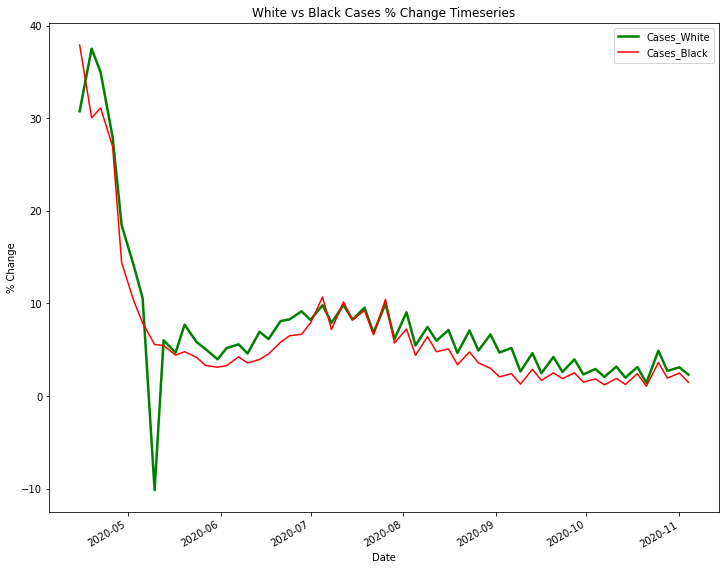

In [73]:
#Percent change for each CRDT data entry shift for White Cases vs Black Cases
cases_white = da[['Date','Cases_White']].sort_values(by='Date')
cases_white.set_index('Date', inplace=True)
cases_white=cases_white.astype('float64')
cases_white_pct=cases_white.pct_change()*100

cases_black = da[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

ax=cases_white_pct.plot(figsize=(12, 10), title='White vs Black Cases % Change Timeseries',linewidth=2.5, color='green'
                     ,ylabel='% Change',xlabel='Date')

cases_black_pct.plot(ax=ax, color='red')

<AxesSubplot:title={'center':'Black vs Asian Cases % Change Timeseries'}, xlabel='Date', ylabel='% Change'>

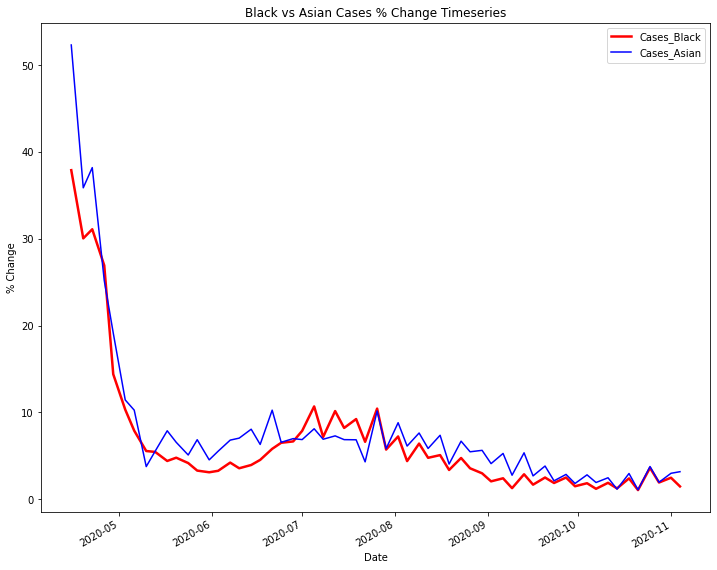

In [74]:
#Percent change for each CRDT data entry shift for Black Cases vs Asian Cases
cases_black = da[['Date','Cases_Black']].sort_values(by='Date')
cases_black.set_index('Date', inplace=True)
cases_black=cases_black.astype('float64')
cases_black_pct=cases_black.pct_change()*100

cases_asian = da[['Date','Cases_Asian']].sort_values(by='Date')
cases_asian.set_index('Date', inplace=True)
cases_asian=cases_asian.astype('float64')
cases_asian_pct=cases_asian.pct_change()*100

ax=cases_black_pct.plot(figsize=(12, 10), title='Black vs Asian Cases % Change Timeseries',linewidth=2.5, color='red'
                     ,ylabel='% Change',xlabel='Date')
cases_asian_pct.plot(ax=ax, color='blue')

# Average Percentage Change for Each Race and Ethnicity

In [127]:
Georgia_Historical_Sorted=Georgia_Historical.set_index('Date').sort_index()
Georgia_Historical_Sorted=Georgia_Historical_Sorted.astype('float64')
Georgia_Historical_PCT=Georgia_Historical_Sorted.pct_change()*100
Georgia_Historical_PCT.mean(axis=0)

Cases_Total                      6.038371
Cases_White                      7.574050
Cases_Black                      6.523649
Cases_LatinX                    13.891803
Cases_Asian                      7.910620
Cases_AIAN                       5.642079
Cases_NHPI                       8.737011
Cases_Multiracial                     inf
Cases_Other                           inf
Cases_Unknown                    4.276973
Cases_Ethnicity_Hispanic         9.060997
Cases_Ethnicity_NonHispanic      6.999355
Cases_Ethnicity_Unknown          5.157167
Deaths_Total                     4.771975
Deaths_White                     5.343639
Deaths_Black                     4.263481
Deaths_LatinX                    6.533602
Deaths_Asian                     5.329177
Deaths_AIAN                      4.911056
Deaths_NHPI                           inf
Deaths_Multiracial                    NaN
Deaths_Other                     4.938432
Deaths_Unknown                  18.045935
Deaths_Ethnicity_Hispanic        5

# Standard Deviation Percentage Change for Each Race and Ethnicity

In [131]:
Georgia_Historical_Sorted=Georgia_Historical.set_index('Date').sort_index()
Georgia_Historical_Sorted=Georgia_Historical_Sorted.astype('float64')
Georgia_Historical_PCT=Georgia_Historical_Sorted.pct_change()*100
Georgia_Historical_PCT.std(axis=0)

Cases_Total                      6.905758
Cases_White                      7.852695
Cases_Black                      7.439850
Cases_LatinX                    63.995537
Cases_Asian                      9.041980
Cases_AIAN                      10.920907
Cases_NHPI                      22.734116
Cases_Multiracial                     NaN
Cases_Other                           NaN
Cases_Unknown                    8.614246
Cases_Ethnicity_Hispanic        11.658772
Cases_Ethnicity_NonHispanic      6.471702
Cases_Ethnicity_Unknown         11.868046
Deaths_Total                     4.223288
Deaths_White                     5.336302
Deaths_Black                     4.382501
Deaths_LatinX                   18.277978
Deaths_Asian                     7.974379
Deaths_AIAN                     18.399929
Deaths_NHPI                           NaN
Deaths_Multiracial                    NaN
Deaths_Other                    23.812927
Deaths_Unknown                  89.824623
Deaths_Ethnicity_Hispanic        5

# Median Percentage Change for Each Race and Ethnicity

In [132]:
Georgia_Historical_Sorted=Georgia_Historical.set_index('Date').sort_index()
Georgia_Historical_Sorted=Georgia_Historical_Sorted.astype('float64')
Georgia_Historical_PCT=Georgia_Historical_Sorted.pct_change()*100
Georgia_Historical_PCT.median(axis=0)

Cases_Total                     4.418746
Cases_White                     5.829863
Cases_Black                     4.403365
Cases_LatinX                    4.122638
Cases_Asian                     5.858055
Cases_AIAN                      2.777778
Cases_NHPI                      4.761905
Cases_Multiracial               0.000000
Cases_Other                     4.175873
Cases_Unknown                   1.284172
Cases_Ethnicity_Hispanic        6.256749
Cases_Ethnicity_NonHispanic     5.119334
Cases_Ethnicity_Unknown         2.322459
Deaths_Total                    3.448782
Deaths_White                    3.483885
Deaths_Black                    3.118869
Deaths_LatinX                   3.759235
Deaths_Asian                    2.846402
Deaths_AIAN                     0.000000
Deaths_NHPI                     0.000000
Deaths_Multiracial                   NaN
Deaths_Other                    4.880952
Deaths_Unknown                  9.591837
Deaths_Ethnicity_Hispanic       4.334365
Deaths_Ethnicity

# Changing the name of the file on path to the current day 
# This closes the file and renames so only run when fully complete with scraping and data quality checks

In [56]:
import os
import datetime
#closes the zip file. 
zf.close()
Current_Date = datetime.datetime.today().strftime ('%d-%b-%Y')
os.rename(r"C:\Users\wjg39\Downloads\ga_covid_data.zip",r"C:\Users\wjg39\Downloads\ga_covid_data_" + str(Current_Date) + '.zip')

#if you get a FileNotFoundError, it is because python has already changed the name. 

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\wjg39\\Downloads\\ga_covid_data.zip' -> 'C:\\Users\\wjg39\\Downloads\\ga_covid_data_05-Nov-2020.zip'